In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os
import json
import pandas as pd

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

ModuleNotFoundError: No module named 'skimage'

### Create a COCO-formatted File for Fashion Data
The maskrnn library can be best used with a COCO object.  This object manages your images and categories for training.  Daata provied by the Fashion challenge is combined to create a single JSON file that holds data in the format used by the COCO object.

Mask rcnn library: <br>
https://github.com/matterport/Mask_RCNN/tree/3deaec5d902d16e1daf56b62d5971d428dc920bc

COCO format: <br>
http://cocodataset.org/#format-data



Fashion files used to create COCO-formatted file:  `train.csc` and `label_descriptions.json`.

A file names `fashion_dictionary.json` will be created in the data source directory when this notebook is executed.

The file is a json file with 5 dictionary entries:<br>

**`info`** - basic info about the file<br>


**`licenses`** - licenses used in the images<br>


**`images`** - a list of dictionaries where each list item is an image
        the dictionary in each list element:<br>
        `license` - the respective license number from the 'license' entry<br>
        `file_name` - name of the file<br>
        `height` - height dimenstion of image<br>
        `width` - width dimenstion of the image<br>
        `id` - id of the image (same as filename without the extension)<br>
        
     
**`annotations`** - list of segmented images in all of the the files. <br>
        `segmentation` - segmentation coordinates<br>
        `area` - <br>
        `iscrowd` - <br>
        `image_id` - respective image id from 'images' entry<br>
        `bbox` - 4 x.y coordinates indicating the bounding box<br>
        `category_id` - respective category id from 'category' entry<br>
        `id` - id of the annotation<br>
        
**`categories`** - list of cateogries in all the images<br>
        `supercateogry` - <br>
        `id` - id if the category<br>
        `name` - name of the category<br>

In [2]:
annotations_dir = '/Users/markmcdonald/Library/Mobile Documents/com~apple~CloudDocs/Harvard/CSCI_E25/Project/libraries/annotations'
coco_data_dir = ''
dataType='train2017'
annFile=os.path.join(annotations_dir, 'instances_{}.json'.format(dataType))


In [3]:
data_dir='/Users/markmcdonald/Desktop/FashionDataSet/'
fashFile=os.path.join(data_dir, 'fashion_dictionary.json')

In [159]:
def create_images(images_file:str) -> (dict, pd.DataFrame):
    
    df_images = pd.read_csv(images_file)
    df_images = df_images.drop(['EncodedPixels', 'ClassId'], axis=1).drop_duplicates()
    df_images.rename(columns={"ImageId":'file_name', "Height":'height', "Width":'width'}, inplace=True)
    df_images['id'] = [x for x in range(len(df_images))]
    
    dict_images = [dict(x[1]) for x in tqdm(df_images.iterrows())]
    
    return dict_images, df_images


In [152]:
def create_info() -> dict:
    
    info_dict = {'year': 2019,
                 'version': '1.0',
                 'description': 'The 2019 FGVC^6 iMaterialist Competition - Fashion track dataset.',
                 'contributor': 'iMaterialist Fashion Competition group',
                 'url': 'https://github.com/visipedia/imat_comp',
                 'date_created': '2019-04-19 12:38:27.493919'}
    
    return info_dict

In [153]:
def create_licenses() -> list:
    
    licenses_list = [{'id':0, 'url':'', 'name':''}]
    
    return licenses_list

In [154]:
def create_categories(cat_file:str) -> dict:
    # read labels file
    with open(cat_file, 'r') as data_file:
        data=data_file.read()

    # parse file
    labels = json.loads(data)
    
    categories = labels.get('categories')
    df_categories = pd.DataFrame(categories)

    dict_categories = [dict(x[1]) for x in df_categories.iterrows()]
    
    return dict_categories

In [276]:
def create_annotations(images_file:str, images:pd.DataFrame) -> dict:
    
    df_images = pd.read_csv(images_file)
    df_images = df_images.drop(['Height', 'Width'], axis=1)
    df_images.rename(columns={"ImageId":'image_id', "ClassId":'category_id', "EncodedPixels":'segmentation'}, inplace=True)
#     df_images['id'] = [images[images.file_name==x]['id'] for x in tqdm(df_images['image_id'])]
    
    dict_annotations = [(dict({"id":x[0], 
                               "image_id":int(images[images.file_name==x[1].image_id]['id'].values[0]),
#                                "image_id":x[1].id,
                               "segmentation":x[1].segmentation,
                               "category_id":x[1].category_id,
                               "area": None,
                               "iscrowd": None,
                               "bbox": None})) for x in tqdm(df_images.iterrows())]

    return dict_annotations

In [277]:
def create_coco_json(data_dir:str, output_file:str=fashFile):
    """
    Creates a json file in COCO format for the Fashion dataset
    """
    # Create the "info" dictionary entry
    info = create_info()
    
    # Create the "licenses" dictionary entry
    licenses = create_licenses()
    
    # Create the "images" dictionary entry
    images_file = os.path.join(data_dir, 'train.csv' )
    images, df_images = create_images(images_file)
    
    # Create the "annotations" dictionary entry
    images_file = os.path.join(data_dir, 'train.csv' )
    annotations = create_annotations(images_file, df_images)
    
    # Create the "categories" dictionary entry 
    cat_file = os.path.join(data_dir, 'label_descriptions.json' )
    categories = create_categories(cat_file)
    
    # Create the dictionary
    coco_dict = {'info':info, 
                 'licenses':licenses, 
                 'images':images,
                 'annotations':annotations,
                 'categories':categories}
    
    # Save dictionary as JSON file
    json_file = json.dumps(coco_dict)
    fp = open(output_file, 'w')
    
    fp.write(json_file)
    fp.close()
    
    pwd = !pwd
    
    print("File saved to: {}/{}".format(pwd, output_file))
    
    return output_file
    
    

In [278]:
# Create the COCO formatted JSON file - takes ~20 minutes
fashFile = create_coco_json(data_dir)


File saved to: ['/Users/markmcdonald/Library/Mobile Documents/com~apple~CloudDocs/Harvard/CSCI_E25/Project/training']//Users/markmcdonald/Desktop/FashionDataSet/fashion_dictionary.json


In [249]:
# Create the "images" dictionary entry
images_file = os.path.join(data_dir, 'train.csv' )
images, df_images = create_images(images_file)

In [250]:
images = df_images

In [255]:
images.head()

,file_name,height,width,id
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,5214,3676,0
9,0000fe7c9191fba733c8a69cfaf962b7.jpg,2448,2448,1
11,0002ec21ddb8477e98b2cbb87ea2e269.jpg,3000,1997,2
15,0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,567,400,3
18,0004467156e47b0eb6de4aa6479cbd15.jpg,750,500,4


In [ ]:
df_images = pd.read_csv(images_file)
df_images = df_images.drop(['Height', 'Width'], axis=1)
df_images.rename(columns={"ImageId":'image_id', "ClassId":'category_id', "EncodedPixels":'segmentation'}, inplace=True)



In [256]:
for x in df_images.iterrows():
    break

In [257]:
x[0]

0

In [269]:
images[images.file_name==x[1].image_id]['id'].values[0]

0

In [254]:
#     df_images['id'] = [images[images.file_name==x]['id'] for x in tqdm(df_images['image_id']) ]

# dict_annotations = [(dict({"id":x[0], 
#                            "image_id":images[images.file_name==x[1].image_id]['id'],
# #                                "image_id":x[1].id,
#                            "segmentation":x[1].segmentation,
#                            "category_id":x[1].category_id,
#                            "area": None,
#                            "iscrowd": None,
#                            "bbox": None})) for x in tqdm(df_images.iterrows())]

In [279]:
# read COCO annotaions file
with open(annFile, 'r') as myfile:
    data=myfile.read()
ann_labels = json.loads(data)

# read fashion_dicionary.json
with open(fashFile, 'r') as myfile:
    data=myfile.read()
fash_labels = json.loads(data)

In [280]:
ann_labels.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [281]:
fash_labels.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [282]:
ann_ann = ann_labels.get('annotations')
fash_ann = fash_labels.get('annotations')
ann_cats = ann_labels.get('categories')
fash_cats = fash_labels.get('categories')
ann_images = ann_labels.get('images')
fash_images = fash_labels.get('images')

In [283]:
ann_ann[0]

{'segmentation': [[239.97,
   260.24,
   222.04,
   270.49,
   199.84,
   253.41,
   213.5,
   227.79,
   259.62,
   200.46,
   274.13,
   202.17,
   277.55,
   210.71,
   249.37,
   253.41,
   237.41,
   264.51,
   242.54,
   261.95,
   228.87,
   271.34]],
 'area': 2765.1486500000005,
 'iscrowd': 0,
 'image_id': 558840,
 'bbox': [199.84, 200.46, 77.71, 70.88],
 'category_id': 58,
 'id': 156}

In [284]:
fash_ann[0]

{'id': 0,
 'image_id': 0,
 'segmentation': '6068157 7 6073371 20 6078584 34 6083797 48 6089010 62 6094223 72 6099436 76 6104649 80 6109862 85 6115075 89 6120288 93 6125501 98 6130714 102 6135927 106 6141140 111 6146354 114 6151567 118 6156780 123 6161993 127 6167206 131 6172419 136 6177632 140 6182845 144 6188058 149 6193271 153 6198484 157 6203697 162 6208910 166 6214124 169 6219337 174 6224550 178 6229763 182 6234976 187 6240189 191 6245402 195 6250615 200 6255828 204 6261041 208 6266254 213 6271467 218 6276680 224 6281893 229 6287107 233 6292320 238 6297533 244 6302746 249 6307959 254 6313172 259 6318385 265 6323598 270 6328811 275 6334024 280 6339237 286 6344450 291 6349663 296 6354877 300 6360090 306 6365303 311 6370516 316 6375729 322 6380942 327 6386155 332 6391368 337 6396581 343 6401794 348 6407007 353 6412220 358 6417433 364 6422647 368 6427860 373 6433073 378 6438286 384 6443499 389 6448712 394 6453925 399 6459138 405 6464351 410 6469564 415 6474777 420 6479990 426 6485203 4

In [285]:
ann_cats[0]

{'supercategory': 'person', 'id': 1, 'name': 'person'}

In [286]:
fash_cats[0].keys()

dict_keys(['id', 'name', 'supercategory', 'level'])

In [287]:
fash_cats[1]

{'id': 1,
 'name': 'top, t-shirt, sweatshirt',
 'supercategory': 'upperbody',
 'level': 2}

In [288]:
fash.getCatIds(catNms = 'jacket')

[4]

In [315]:
ann_ann[0].get('segmentation')

[[239.97,
  260.24,
  222.04,
  270.49,
  199.84,
  253.41,
  213.5,
  227.79,
  259.62,
  200.46,
  274.13,
  202.17,
  277.55,
  210.71,
  249.37,
  253.41,
  237.41,
  264.51,
  242.54,
  261.95,
  228.87,
  271.34]]

In [317]:
fash_ann[0].get('segmentation')

'6068157 7 6073371 20 6078584 34 6083797 48 6089010 62 6094223 72 6099436 76 6104649 80 6109862 85 6115075 89 6120288 93 6125501 98 6130714 102 6135927 106 6141140 111 6146354 114 6151567 118 6156780 123 6161993 127 6167206 131 6172419 136 6177632 140 6182845 144 6188058 149 6193271 153 6198484 157 6203697 162 6208910 166 6214124 169 6219337 174 6224550 178 6229763 182 6234976 187 6240189 191 6245402 195 6250615 200 6255828 204 6261041 208 6266254 213 6271467 218 6276680 224 6281893 229 6287107 233 6292320 238 6297533 244 6302746 249 6307959 254 6313172 259 6318385 265 6323598 270 6328811 275 6334024 280 6339237 286 6344450 291 6349663 296 6354877 300 6360090 306 6365303 311 6370516 316 6375729 322 6380942 327 6386155 332 6391368 337 6396581 343 6401794 348 6407007 353 6412220 358 6417433 364 6422647 368 6427860 373 6433073 378 6438286 384 6443499 389 6448712 394 6453925 399 6459138 405 6464351 410 6469564 415 6474777 420 6479990 426 6485203 431 6490416 436 6495630 441 6500843 446 6506

In [ ]:
fash_images[0]

In [291]:
# initialize COCO api for instance annotations
coco=COCO(annFile)
fash=COCO(fashFile)

loading annotations into memory...
Done (t=13.46s)
creating index...
index created!
loading annotations into memory...
Done (t=11.36s)
creating index...
index created!


In [292]:
# COCO
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print ('COCO categories: \n\n', ' '.join(nms))

nms = set([cat['supercategory'] for cat in cats])
print ('COCO supercategories: \n', ' '.join(nms))

COCO categories: 

 person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush
COCO supercategories: 
 person kitchen furniture accessory appliance indoor vehicle food sports electronic outdoor animal


In [293]:
# FASHION
# display COCO categories and supercategories
cats = fash.loadCats(fash.getCatIds())
nms=[cat['name'] for cat in cats]
print ('COCO categories: \n\n', ' '.join(nms))

nms = set([cat['supercategory'] for cat in cats])
print ('COCO supercategories: \n', ' '.join(nms))

COCO categories: 

 shirt, blouse top, t-shirt, sweatshirt sweater cardigan jacket vest pants shorts skirt coat dress jumpsuit cape glasses hat headband, head covering, hair accessory tie glove watch belt leg warmer tights, stockings sock shoe bag, wallet scarf umbrella hood collar lapel epaulette sleeve pocket neckline buckle zipper applique bead bow flower fringe ribbon rivet ruffle sequin tassel
COCO supercategories: 
 others arms and hands head garment parts decorations waist closures lowerbody upperbody neck wholebody legs and feet


In [294]:
# COCO
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
imgIds = coco.getImgIds(catIds=catIds);
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [295]:
img

{'license': 3,
 'file_name': '000000023737.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000023737.jpg',
 'height': 500,
 'width': 333,
 'date_captured': '2013-11-18 08:12:02',
 'flickr_url': 'http://farm3.staticflickr.com/2580/3858562224_2bedcaa944_z.jpg',
 'id': 23737}

In [296]:
img.get('coco_url')

'http://images.cocodataset.org/train2017/000000023737.jpg'

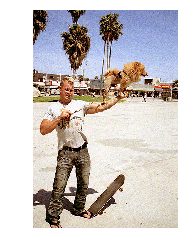

In [297]:
# load and display image
# I = io.imread(os.path.join(dataDir, 'images', dataType, img['file_name']))
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
# I = io.imread('http://mscoco.org/images/%d'%(img['id']))
I = io.imread(img.get('coco_url'))
plt.figure(); plt.axis('off')
plt.imshow(I)
plt.show()

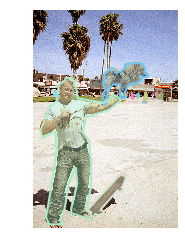

In [298]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [299]:
annIds

[16247,
 189201,
 256385,
 645218,
 1205477,
 1214489,
 1244147,
 1274492,
 1275801,
 1276168,
 1477918]

In [300]:
# FASHION
# get all images containing given categories, select one at random
# catIds = fash.getCatIds(catNms=['sweater','jacket','purse']);
catIds = fash.getCatIds();
imgIds = fash.getImgIds()   #(catIds=catIds);
img = fash.loadImgs(imgIds[np.random.randint(0,len(imgIds))]  )[0]

In [301]:
img

{'file_name': '5227dc58247ee256a101ec58db8262d2.jpg',
 'height': 3264,
 'width': 2674,
 'id': 14693}

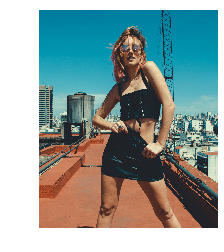

In [302]:
# load and display image
I = io.imread(os.path.join(data_dir, 'train', img.get('file_name')))

plt.figure(); plt.axis('off')
plt.imshow(I)
plt.show()

In [307]:
fash.getAnnIds(imgIds=img['id'])

[107274, 107275, 107276, 107277]

In [312]:
anns

[{'id': 107274,
  'image_id': 14693,
  'segmentation': '3018319 20 3021578 28 3024837 36 3028097 43 3031356 50 3034615 56 3037874 63 3041133 69 3044391 77 3047650 83 3050898 101 3054135 129 3057381 149 3060635 160 3063889 172 3067143 184 3070397 195 3073652 206 3076906 217 3080160 228 3083416 237 3086675 243 3089934 248 3093193 254 3096452 260 3099711 266 3102970 271 3106229 277 3109488 283 3112747 289 3116006 294 3119264 301 3122524 306 3125785 309 3129046 313 3132307 317 3135568 321 3138829 324 3142090 328 3145351 332 3148612 336 3151873 339 3155134 343 3158396 345 3161657 348 3164919 351 3168181 353 3171443 356 3174704 359 3177966 362 3181228 364 3184490 366 3187751 370 3191013 372 3194275 375 3197536 378 3200798 381 3204060 383 3207322 386 3210583 389 3213845 391 3217107 394 3220369 396 3223630 400 3226892 402 3230154 405 3233415 408 3236677 410 3239939 413 3243201 415 3246435 6 3246462 419 3249698 19 3249724 421 3252961 449 3256224 450 3259487 451 3262751 452 3266014 453 3269277 4

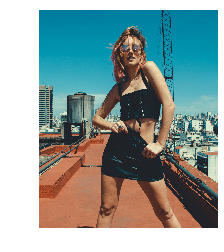

In [311]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
# annIds = fash.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
annIds = fash.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = fash.loadAnns(annIds)

TypeError: string indices must be integers

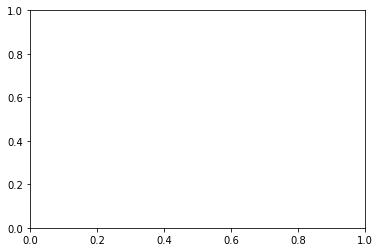

In [313]:

fash.showAnns(anns)

In [10]:
# initialize COCO api for person keypoints annotations
annFile = '%s/annotations/person_keypoints_%s.json'%(dataDir,dataType)
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=13.65s)
creating index...
index created!


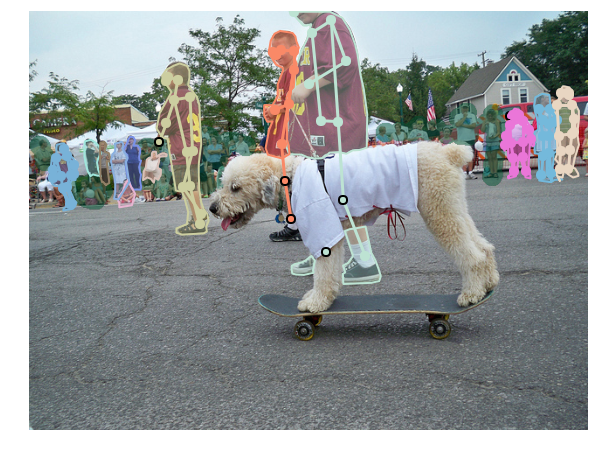

In [11]:
# load and display keypoints annotations
plt.imshow(I); plt.axis('off')
ax = plt.gca()
annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_kps.loadAnns(annIds)
coco_kps.showAnns(anns)

In [12]:
# initialize COCO api for caption annotations
annFile = '%s/annotations/captions_%s.json'%(dataDir,dataType)
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=4.08s)
creating index...
index created!


A small brown dog wearing a white shirt on top of a skateboard.
A dog wearing a t-shirt while riding on a skateboard.
Dog on skateboard wearing t-shirt during parade event.
A large poodle takes part in a parade by riding a skateboard.
A dog is on a leash while riding on a skateboard.  


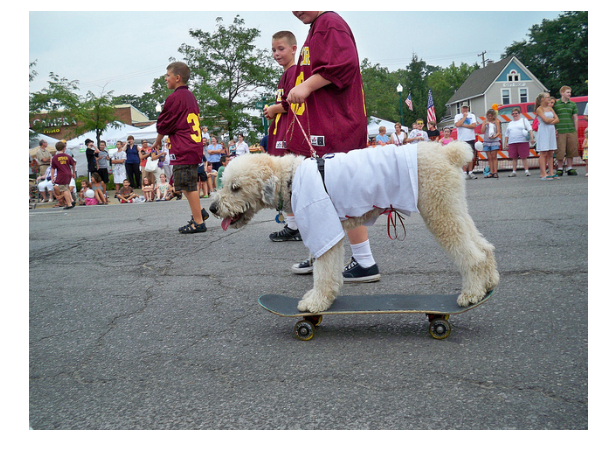

In [13]:
# load and display caption annotations
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.imshow(I); plt.axis('off')
plt.show()